## 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import calendar

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

import xgboost as xgb

## 1. Set Up Constants

In [2]:
TEST_SIZE = 0.2
SEQUENCE_LENGTH = 14
RANDOM_STATE_SEED = 42

RSI_ROLLING_WINDOW_SIZE = 14

XGB_TEST_SIZE = 0.3
XGB_N_ESTIMATORS = 475
XGB_MAX_DEPTH = 9
XGB_LEARNING_RATE = 0.009
XGB_COLSAMPLE_BYTREE = 1.0
XGB_MIN_CHILD_WEIGHT = 23
XGB_SUBSAMPLE = 1.0
XGB_GAMMA = 0.28

## 2. Original S&P 500 Dataset

In [3]:
"""
Assume that today is 2nd Jan 2025 and it is before market opening in the S&P500:

 - ARIMA: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today

 - GRU: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today

But i need to wait for market closing of 2nd Jan 2025 to obtain the actual results of the S&P500 prices,
so that I can calculate the prediction error of both models.

With prediction errors of 1nd Jan and actual S&P 500 price of 2nd Jan, i can predict price of tomorrow (3rd Jan)

 - XGB: 
    --> Price data of yesterday (1st Jan) to predict via ARIMA and GRU
    --> Obtain prediction error by today (2nd Jan)
    --> Using both prediction error (2nd Jan) and price data (2nd Jan) to predict tomorrow (3rd Jan)
"""

'\nAssume that today is 2nd Jan 2025 and it is before market opening in the S&P500:\n\n - ARIMA: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today\n\n - GRU: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today\n\nBut i need to wait for market closing of 2nd Jan 2025 to obtain the actual results of the S&P500 prices,\nso that I can calculate the prediction error of both models.\n\nWith prediction errors of 1nd Jan and actual S&P 500 price of 2nd Jan, i can predict price of tomorrow (3rd Jan)\n\n - XGB: \n    --> Price data of yesterday (1st Jan) to predict via ARIMA and GRU\n    --> Obtain prediction error by today (2nd Jan)\n    --> Using both prediction error (2nd Jan) and price data (2nd Jan) to predict tomorrow (3rd Jan)\n'

#### Read Datset

In [4]:
file_name = "SP500_forMacro.csv"

folder_name = "data"

folder_path = os.path.join(os.getcwd(), folder_name)

if os.path.isdir(folder_path):
    
    dataset_file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(dataset_file_path, index_col=False)
    
    print(f"Dataset has been read from {dataset_file_path}.")

else:
    print(f"Folder {folder_name} is not found at {folder_path}.")

Dataset has been read from c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\data\SP500_forMacro.csv.


#### Processing Original SP500 Dataset to Obtain Alligned Data with Errors

In [5]:
# Fill Missing Values

df['SP500'] = df['SP500'].ffill()

In [6]:
# Set Index as Observation Date

df['observation_date'] = pd.to_datetime(df['observation_date'])

df.set_index('observation_date', inplace=True)

In [7]:
df.head()

,SP500
observation_date,
2018-04-02,2581.88
2018-04-03,2614.45
2018-04-04,2644.69
2018-04-05,2662.84
2018-04-06,2604.47


In [8]:
# Dropout first 13 days of data due to missing data from GRU features (SMI)

df = df.iloc[(RSI_ROLLING_WINDOW_SIZE-1):]

In [9]:
df.head()

,SP500
observation_date,
2018-04-19,2693.13
2018-04-20,2670.14
2018-04-23,2670.29
2018-04-24,2634.56
2018-04-25,2639.40


In [10]:
# Columns = 'SP500'
y = df['SP500']

X = df.copy(deep=True)

In [11]:
## Train test split was done to find length of test dataset which is what we need

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE_SEED, 
                                                    shuffle=False)

In [12]:
print(f"Length of X_train: {len(X_train)}")
print(f"Lenth of y_train: {len(y_train)}")

print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 1501
Lenth of y_train: 1501
Length of X_test: 376
Length of y_test: 376


In [13]:
def create_sequence(X_df, y_df, seq_length):
    new_X = []

    new_y = []
    
    for i in range(0, (len(y_df) - seq_length)):

        temp_X = None

        # If it is a DataFrame, index it in 2-dimensions
        if isinstance(X_df, pd.DataFrame):
            temp_X = X_df.iloc[i:(i+seq_length), :]

        else:
            temp_X = X_df.iloc[i:(i+seq_length)]

        temp_y = y_df.iloc[i+seq_length]

        temp_X = np.squeeze(temp_X.values)

        new_X.append(temp_X.tolist())

        new_y.append(temp_y)
    
    return new_X, new_y

In [14]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [15]:
X_test.head()

,SP500
observation_date,
2024-01-19,4839.81
2024-01-22,4850.43
2024-01-23,4864.60
2024-01-24,4868.55
2024-01-25,4894.16


In [16]:
def create_sequences_with_index(X_ori, y_ori, window_size):
    X, y = [], []
    
    # Convert dataframe to numpy for faster iteration
    X_data_values = X_ori.values
    y_data_values = y_ori.values
    
    for i in range(window_size, len(X_ori)):
        # Get the sequence of features for the window
        temp_X = X_data_values[i-window_size : i]
        temp_X = np.squeeze(temp_X)

        X.append(temp_X)
        
        # Get the target value for the current day
        y.append(y_data_values[i])
        
    # Retain the index of the day being predicted
    target_index = X_ori.index[window_size:]

    X = np.array(X)
    y = np.array(y)
        
    return X, y, pd.to_datetime(target_index)

In [17]:
#X_test, y_test = create_sequence(X_test, y_test, seq_length=SEQUENCE_LENGTH)

In [18]:
X_test, y_test, date = create_sequences_with_index(X_test, y_test, 
                                                   window_size=SEQUENCE_LENGTH)

In [19]:
print(f"Number of sequences of y_test: {len(y_test)}")

print(f"Size of y_test: [{len(y_test)}, 1]")

Number of sequences of y_test: 362
Size of y_test: [362, 1]


#### Conversion into Pandas DataFrame

In [20]:
y_test_dict = {'SP500': y_test}

y_test_pd = pd.DataFrame(y_test_dict, index=date)

In [21]:
y_test_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   362 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [22]:
print(y_test_pd)

                    SP500
observation_date         
2024-02-08        4997.91
2024-02-09        5026.61
2024-02-12        5021.84
2024-02-13        4953.17
2024-02-14        5000.62
...                   ...
2025-06-23        6025.17
2025-06-24        6092.18
2025-06-25        6092.16
2025-06-26        6141.02
2025-06-27        6173.07

[362 rows x 1 columns]


## 3. GRU and ARIMA Prediction Error Files

#### Read VIXCLS File (CBOE Volatility Index)

In [23]:
"""
The CBOE Volatility Index (VIX), also known as the Fear Index, 
measures expected market volatility using a portfolio of options on the S&P 500.
"""

'\nThe CBOE Volatility Index (VIX), also known as the Fear Index, \nmeasures expected market volatility using a portfolio of options on the S&P 500.\n'

In [24]:
folder_name = 'data'

vix_filename = "VIXCLS.csv"

vix_filepath = os.path.join(os.getcwd(), folder_name, vix_filename)

In [25]:
if os.path.exists(vix_filepath):
    vix_pd = pd.read_csv(vix_filepath, index_col=False)

    print(f"VIXCLS file successfully read from:\n{vix_filepath}\n")
else:
    print(f"ERROR: VIXCLS file does not exists at:\n{vix_filepath}\n")

VIXCLS file successfully read from:
c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\data\VIXCLS.csv



In [26]:
vix_pd['observation_date'] = pd.to_datetime(vix_pd['observation_date'])

vix_pd = vix_pd.set_index('observation_date')

In [27]:
print(vix_pd)

                  VIXCLS
observation_date        
1990-01-02         17.24
1990-01-03         18.19
1990-01-04         19.22
1990-01-05         20.11
1990-01-08         20.26
...                  ...
2025-11-06         19.50
2025-11-07         19.08
2025-11-10         17.60
2025-11-11         17.28
2025-11-12         17.51

[9357 rows x 1 columns]


In [28]:
vix_pd.isnull().sum()

VIXCLS    299
dtype: int64

In [29]:
vix_pd = vix_pd.ffill()

In [30]:
vix_pd.isnull().sum()

VIXCLS    0
dtype: int64

#### Read Saved Prediction Errors CSV

In [31]:
folder_name = 'processed_data'

gru_error_filename = "gru_error.csv"
arima_error_filename = "arima_error.csv"
rw_error_filename = "rw_arima_error.csv"

gru_error_filepath = os.path.join(os.getcwd(), folder_name, gru_error_filename)
arima_error_filepath = os.path.join(os.getcwd(), folder_name, arima_error_filename)
rw_error_filepath = os.path.join(os.getcwd(), folder_name, rw_error_filename)

In [32]:
if os.path.exists(gru_error_filepath):
    gru_error_pd = pd.read_csv(gru_error_filepath, index_col=False)

    print(f"GRU prediction error file successfully read from:\n{gru_error_filepath}\n")
else:
    print(f"ERROR: GRU prediction error file does not exists at:\n{gru_error_filepath}\n")

if os.path.exists(arima_error_filepath):
    arima_error_pd = pd.read_csv(arima_error_filepath, index_col=False)

    print(f"ARIMA prediction error file successfully read from:\n{arima_error_filepath}\n")
else:
    print(f"ERROR: ARIMA prediction error file does not exists at:\n{arima_error_filepath}\n")

if os.path.exists(rw_error_filepath):
    rw_error_pd = pd.read_csv(rw_error_filepath, index_col=False)

    print(f"Random walk prediction error file successfully read from:\n{rw_error_filepath}\n")
else:
    print(f"ERROR: Random walk prediction error file does not exists at:\n{rw_error_filepath}\n")

GRU prediction error file successfully read from:
c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\processed_data\gru_error.csv

ARIMA prediction error file successfully read from:
c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\processed_data\arima_error.csv

Random walk prediction error file successfully read from:
c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\processed_data\rw_arima_error.csv



#### Datasets Information

In [33]:
arima_error_pd.index = date

arima_error_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Arima Error  362 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [34]:
gru_error_pd.index = date

gru_error_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GRU Error  362 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [35]:
rw_error_pd.index = date

print(rw_error_pd)

                  RW Arima Error
observation_date                
2024-02-08                  2.85
2024-02-09                 28.70
2024-02-12                 -4.77
2024-02-13                -68.67
2024-02-14                 47.45
...                          ...
2025-06-23                 57.33
2025-06-24                 67.01
2025-06-25                 -0.02
2025-06-26                 48.86
2025-06-27                 32.05

[362 rows x 1 columns]


In [36]:
print(arima_error_pd)

                  Arima Error
observation_date             
2024-02-08           6.932583
2024-02-09          28.984603
2024-02-12          -1.901878
2024-02-13         -69.146173
2024-02-14          40.600359
...                       ...
2025-06-23          56.168985
2025-06-24          72.116304
2025-06-25           5.898945
2025-06-26          48.858234
2025-06-27          36.365361

[362 rows x 1 columns]


In [37]:
print(gru_error_pd)

                   GRU Error
observation_date            
2024-02-08          0.513516
2024-02-09         30.852188
2024-02-12         -4.984707
2024-02-13        -64.679121
2024-02-14         51.232305
...                      ...
2025-06-23        102.401934
2025-06-24        108.375801
2025-06-25         56.831875
2025-06-26        111.999980
2025-06-27         93.060723

[362 rows x 1 columns]


## 4. Data Pre-Processing

#### Combine Both Model Prediction Errors

In [38]:
error_df = pd.concat([y_test_pd, arima_error_pd, gru_error_pd, rw_error_pd],
                     axis=1,
                     ignore_index=True)

error_df = error_df.rename({0: "SP500", 
                            1: "ARIMA Error", 
                            2: "GRU Error",
                            3: "RW Error"},
                            axis=1)

In [39]:
error_df.head()

,SP500,ARIMA Error,GRU Error,RW Error
observation_date,,,,
2024-02-08,4997.91,6.932583,0.513516,2.85
2024-02-09,5026.61,28.984603,30.852188,28.70
2024-02-12,5021.84,-1.901878,-4.984707,-4.77
2024-02-13,4953.17,-69.146173,-64.679121,-68.67
2024-02-14,5000.62,40.600359,51.232305,47.45


In [40]:
error_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SP500        362 non-null    float64
 1   ARIMA Error  362 non-null    float64
 2   GRU Error    362 non-null    float64
 3   RW Error     362 non-null    float64
dtypes: float64(4)
memory usage: 14.1 KB


In [41]:
error_df.describe()

,SP500,ARIMA Error,GRU Error,RW Error
count,362.000000,362.000000,362.000000,362.000000
mean,5608.810304,3.569228,32.856977,3.254171
std,338.549480,59.993949,61.489857,59.873823
min,4953.170000,-348.334891,-288.575273,-322.440000
25%,5305.050000,-19.558409,0.879233,-17.442500
50%,5628.620000,5.470772,33.823984,4.555000
75%,5918.250000,33.879741,65.335386,32.580000
max,6173.070000,469.153425,467.504492,474.130000


In [42]:
error_df.isnull().sum()

SP500          0
ARIMA Error    0
GRU Error      0
RW Error       0
dtype: int64

In [43]:
print(error_df)

                    SP500  ARIMA Error   GRU Error  RW Error
observation_date                                            
2024-02-08        4997.91     6.932583    0.513516      2.85
2024-02-09        5026.61    28.984603   30.852188     28.70
2024-02-12        5021.84    -1.901878   -4.984707     -4.77
2024-02-13        4953.17   -69.146173  -64.679121    -68.67
2024-02-14        5000.62    40.600359   51.232305     47.45
...                   ...          ...         ...       ...
2025-06-23        6025.17    56.168985  102.401934     57.33
2025-06-24        6092.18    72.116304  108.375801     67.01
2025-06-25        6092.16     5.898945   56.831875     -0.02
2025-06-26        6141.02    48.858234  111.999980     48.86
2025-06-27        6173.07    36.365361   93.060723     32.05

[362 rows x 4 columns]


#### Concat DFF into Error DF

In [44]:
error_df = pd.concat([error_df, vix_pd],
                     axis=1)

In [45]:
error_df.isnull().sum()

SP500          8995
ARIMA Error    8995
GRU Error      8995
RW Error       8995
VIXCLS            0
dtype: int64

In [46]:
error_df.dropna(inplace=True)

In [47]:
print(error_df)

                    SP500  ARIMA Error   GRU Error  RW Error  VIXCLS
observation_date                                                    
2024-02-08        4997.91     6.932583    0.513516      2.85   12.79
2024-02-09        5026.61    28.984603   30.852188     28.70   12.93
2024-02-12        5021.84    -1.901878   -4.984707     -4.77   13.93
2024-02-13        4953.17   -69.146173  -64.679121    -68.67   15.85
2024-02-14        5000.62    40.600359   51.232305     47.45   14.38
...                   ...          ...         ...       ...     ...
2025-06-23        6025.17    56.168985  102.401934     57.33   19.83
2025-06-24        6092.18    72.116304  108.375801     67.01   17.48
2025-06-25        6092.16     5.898945   56.831875     -0.02   16.76
2025-06-26        6141.02    48.858234  111.999980     48.86   16.59
2025-06-27        6173.07    36.365361   93.060723     32.05   16.32

[362 rows x 5 columns]


#### Feature Engineering

In [48]:
## Feature Engineering of VIX data

def vix_feature_engineering(ori_df):
    
    df = ori_df.copy()

    # Log Returns
    df['VIX_Log_Ret'] = np.log(df['VIXCLS'] / df['VIXCLS'].shift(1))

    # Rolling Z-Score (20-day)
    vix_mean = df['VIXCLS'].rolling(window=20).mean()
    vix_std = df['VIXCLS'].rolling(window=20).std()
    df['VIX_ZScore'] = (df['VIXCLS'] - vix_mean) / vix_std

    # VIX Momentum (Short-term velocity)
    df['VIX_ROC_3'] = df['VIXCLS'].pct_change(periods=3)

    # Spike Indicator (Binary)
    df['VIX_Spike'] = (df['VIX_Log_Ret'] > df['VIX_Log_Ret'].rolling(50).std() * 2).astype(int)

    return df


In [49]:
def week_of_month(tgtdate):

    days_this_month = calendar.mdays[tgtdate.month]

    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break

    # now we can use the modulo 7 appraoch
    return ((tgtdate - startdate).days //7 + 1) + 1

In [50]:
## Datetime Features

def datetime_feature_engineering(df):
    df.reset_index(inplace=True)

    df['Day of Month'] = df['observation_date'].dt.day

    df['Month End'] = df['observation_date'].dt.is_month_end.astype(int)

    df['Quarter End'] = df['observation_date'].dt.is_quarter_end.astype(int)

    df = df.set_index('observation_date', drop=True)

    return df

In [51]:
error_df = datetime_feature_engineering(error_df)

In [52]:
def error_feature_engineering(ori_df):

    df = ori_df.copy()

    ## Prediction error of previous 2 days 
    df['ARIMA Error Lag1'] = df['ARIMA Error'].shift(1)
    df['GRU Error Lag1'] = df['GRU Error'].shift(1)

    ## Rolling Statistics (Volatility of Predictions)
    df['ARIMA Vol_12d'] = df['ARIMA Error'].rolling(window=12).std()
    df['GRU Vol_12d'] = df['GRU Error'].rolling(window=12).std()

    ## Mean Error of 12 Days
    df['ARIMA Bias_12d'] = df['ARIMA Error'].rolling(window=12).mean()
    df['GRU Bias_12d'] = df['GRU Error'].rolling(window=12).mean()

    ## 12-Day Error Correlation between ARIMA and GRU
    df['Error Corr_12d'] = df['ARIMA Error'].rolling(12).corr(df['GRU Error'])

    ## Absolute Difference Between Errors (Difference in direction and magnitude of models predictions)
    df['Error Diff'] = (df['ARIMA Error'] - df['GRU Error']).abs()

    ## Volatility Ratio
    # We add a tiny epsilon (1e-9) to avoid division by zero
    df['Vol Ratio'] = df['ARIMA Vol_12d'] / (df['GRU Vol_12d'] + 1e-9)

    ## Gating Weight (Determines to trust ARIMA or GRU more)
    # This maps the ratio to a 0-1 scale using a sigmoid function
    # If ratio is 1.0, weight is 0.5 (equal trust)
    df['Gating Weight'] = 1 / (1 + np.exp(-(df['Vol Ratio'] - 1)))

    ## Final Gated Prediction
    # High vol_ratio -> More weight to GRU
    # Low vol_ratio -> More weight to ARIMA
    df['Error Hybrid Gated'] = (df['ARIMA Error'] * (1 - df['Gating Weight'])) + (df['GRU Error'] * df['Gating Weight'])

    # Drop rows with missing values
    df = df.dropna(axis=0)
    
    return df

In [53]:
error_df.head()

,SP500,ARIMA Error,GRU Error,RW Error,VIXCLS,Day of Month,Month End,Quarter End
observation_date,,,,,,,,
2024-02-08,4997.91,6.932583,0.513516,2.85,12.79,8,0,0
2024-02-09,5026.61,28.984603,30.852188,28.70,12.93,9,0,0
2024-02-12,5021.84,-1.901878,-4.984707,-4.77,13.93,12,0,0
2024-02-13,4953.17,-69.146173,-64.679121,-68.67,15.85,13,0,0
2024-02-14,5000.62,40.600359,51.232305,47.45,14.38,14,0,0


In [54]:
error_df.tail()

,SP500,ARIMA Error,GRU Error,RW Error,VIXCLS,Day of Month,Month End,Quarter End
observation_date,,,,,,,,
2025-06-23,6025.17,56.168985,102.401934,57.33,19.83,23,0,0
2025-06-24,6092.18,72.116304,108.375801,67.01,17.48,24,0,0
2025-06-25,6092.16,5.898945,56.831875,-0.02,16.76,25,0,0
2025-06-26,6141.02,48.858234,111.999980,48.86,16.59,26,0,0
2025-06-27,6173.07,36.365361,93.060723,32.05,16.32,27,0,0


#### Dataset Split

In [55]:
train_size = int((1 - XGB_TEST_SIZE )* len(error_df))

train_df = error_df.iloc[:train_size, :]
test_df = error_df.iloc[train_size:, :]

In [56]:
train_df = vix_feature_engineering(train_df)
train_df = error_feature_engineering(train_df)

test_df = vix_feature_engineering(test_df)
test_df = error_feature_engineering(test_df)

In [57]:
print(f"{len(train_df)}\n")

print(train_df)

234

                    SP500  ARIMA Error   GRU Error  RW Error  VIXCLS  \
observation_date                                                       
2024-03-06        5104.76    20.894956   32.553945     26.11   14.50   
2024-03-07        5157.36    55.214054   45.677383     52.60   14.44   
2024-03-08        5123.69   -28.434905  -29.674746    -33.67   14.74   
2024-03-11        5117.94    -9.118428    4.935117     -5.75   15.22   
2024-03-12        5175.27    56.755667   55.469219     57.33   13.84   
...                   ...          ...         ...       ...     ...   
2025-01-21        6049.24    52.580000  117.235605     52.58   15.06   
2025-01-22        6086.37    41.519078   98.202031     37.13   15.10   
2025-01-23        6118.71    35.414086  102.166055     32.34   15.02   
2025-01-24        6101.24   -14.805147   57.710215    -17.47   14.85   
2025-01-27        6012.28   -90.402586  -16.953887    -88.96   17.90   

                  Day of Month  Month End  Quarter End  VI

In [58]:
print(f"{len(test_df)}\n")

print(test_df)

90

                    SP500  ARIMA Error   GRU Error  RW Error  VIXCLS  \
observation_date                                                       
2025-02-24        5983.25   -38.699000   26.297852    -29.88   18.98   
2025-02-25        5955.25   -30.485433   12.028809    -28.00   19.43   
2025-02-26        5956.06    -1.511557   44.930605      0.81   19.10   
2025-02-27        5861.57   -94.422898  -52.280586    -94.49   21.13   
2025-02-28        5954.50    85.096480  134.926270     92.93   19.63   
...                   ...          ...         ...       ...     ...   
2025-06-23        6025.17    56.168985  102.401934     57.33   19.83   
2025-06-24        6092.18    72.116304  108.375801     67.01   17.48   
2025-06-25        6092.16     5.898945   56.831875     -0.02   16.76   
2025-06-26        6141.02    48.858234  111.999980     48.86   16.59   
2025-06-27        6173.07    36.365361   93.060723     32.05   16.32   

                  Day of Month  Month End  Quarter End  VIX

#### Correlation Matrix

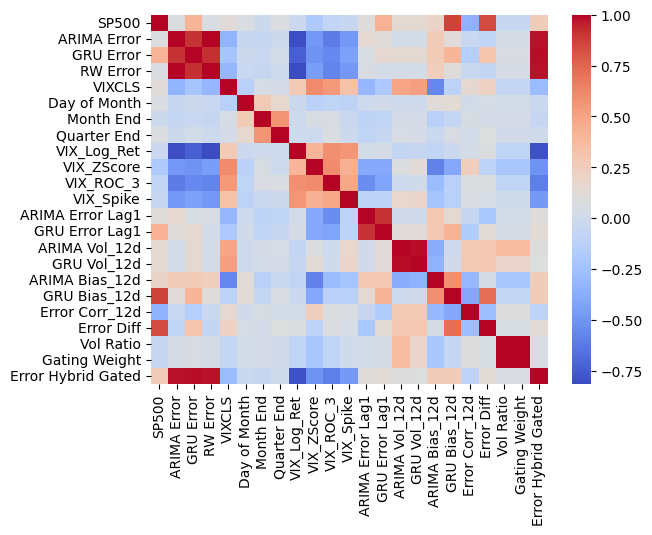

In [59]:
corr_mat = train_df.corr()

sns.heatmap(corr_mat, cmap='coolwarm')

plt.show()

#### Dataset Sequencing

In [60]:
def split_X_y(df):
    y = df['SP500'].shift(-1)

    y.dropna(inplace=True)

    X = df.copy()

    # Don't have tomorrow's data to train on the last row so drop it
    X = X.iloc[:-1, :]

    return X, y

In [61]:
X_train, y_train = split_X_y(train_df)

X_test, y_test = split_X_y(test_df)

In [62]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}\n")

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (233, 23)
Shape of y_train: (233,)

Shape of X_test: (89, 23)
Shape of y_test: (89,)


In [63]:
print(X_train)

                    SP500  ARIMA Error   GRU Error  RW Error  VIXCLS  \
observation_date                                                       
2024-03-06        5104.76    20.894956   32.553945     26.11   14.50   
2024-03-07        5157.36    55.214054   45.677383     52.60   14.44   
2024-03-08        5123.69   -28.434905  -29.674746    -33.67   14.74   
2024-03-11        5117.94    -9.118428    4.935117     -5.75   15.22   
2024-03-12        5175.27    56.755667   55.469219     57.33   13.84   
...                   ...          ...         ...       ...     ...   
2025-01-20        5996.66     4.957031   52.407070      0.00   15.81   
2025-01-21        6049.24    52.580000  117.235605     52.58   15.06   
2025-01-22        6086.37    41.519078   98.202031     37.13   15.10   
2025-01-23        6118.71    35.414086  102.166055     32.34   15.02   
2025-01-24        6101.24   -14.805147   57.710215    -17.47   14.85   

                  Day of Month  Month End  Quarter End  VIX_Log

In [64]:
print(y_train)

observation_date
2024-03-06    5157.36
2024-03-07    5123.69
2024-03-08    5117.94
2024-03-11    5175.27
2024-03-12    5165.31
               ...   
2025-01-20    6049.24
2025-01-21    6086.37
2025-01-22    6118.71
2025-01-23    6101.24
2025-01-24    6012.28
Name: SP500, Length: 233, dtype: float64


In [65]:
print(X_test)

                    SP500  ARIMA Error   GRU Error  RW Error  VIXCLS  \
observation_date                                                       
2025-02-24        5983.25   -38.699000   26.297852    -29.88   18.98   
2025-02-25        5955.25   -30.485433   12.028809    -28.00   19.43   
2025-02-26        5956.06    -1.511557   44.930605      0.81   19.10   
2025-02-27        5861.57   -94.422898  -52.280586    -94.49   21.13   
2025-02-28        5954.50    85.096480  134.926270     92.93   19.63   
...                   ...          ...         ...       ...     ...   
2025-06-20        5967.84   -13.030000   26.317539    -13.03   20.62   
2025-06-23        6025.17    56.168985  102.401934     57.33   19.83   
2025-06-24        6092.18    72.116304  108.375801     67.01   17.48   
2025-06-25        6092.16     5.898945   56.831875     -0.02   16.76   
2025-06-26        6141.02    48.858234  111.999980     48.86   16.59   

                  Day of Month  Month End  Quarter End  VIX_Log

In [66]:
print(y_test)

observation_date
2025-02-24    5955.25
2025-02-25    5956.06
2025-02-26    5861.57
2025-02-27    5954.50
2025-02-28    5849.72
               ...   
2025-06-20    6025.17
2025-06-23    6092.18
2025-06-24    6092.16
2025-06-25    6141.02
2025-06-26    6173.07
Name: SP500, Length: 89, dtype: float64


In [67]:
# Obtain prediction list of random walk which fits the dataset sliced

rw_pred_lst = np.array(X_test['SP500']) - np.array(X_test['RW Error'])

In [68]:
## Drop unrequired random walk error (Used to only for matching purposes)

X_train.drop('RW Error', axis=1, inplace=True)
X_test.drop('RW Error', axis=1, inplace=True)

#### Sample Weights

In [69]:
X_train.describe()

,SP500,ARIMA Error,GRU Error,VIXCLS,Day of Month,Month End,Quarter End,VIX_Log_Ret,VIX_ZScore,VIX_ROC_3,...,GRU Error Lag1,ARIMA Vol_12d,GRU Vol_12d,ARIMA Bias_12d,GRU Bias_12d,Error Corr_12d,Error Diff,Vol Ratio,Gating Weight,Error Hybrid Gated
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,...,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,5570.219657,4.773954,31.525249,16.003047,15.665236,0.025751,0.008584,0.000114,0.029156,0.013254,...,31.084679,41.586518,41.132364,4.242242,29.687997,0.971791,27.112764,1.005728,0.501427,18.205822
std,315.654762,44.710818,47.313346,3.423300,8.694997,0.158733,0.092448,0.086877,1.176439,0.171644,...,47.545835,16.358106,15.209561,12.372065,20.237971,0.030045,18.799635,0.080717,0.020149,45.001306
min,4967.230000,-180.565213,-140.475664,11.860000,1.000000,0.000000,0.000000,-0.330681,-2.369242,-0.407638,...,-140.475664,16.660514,17.404395,-32.435173,-13.653442,0.721655,0.022711,0.831316,0.457929,-154.549801
25%,5291.340000,-16.183737,4.935117,13.420000,8.000000,0.000000,0.000000,-0.035677,-0.826697,-0.062794,...,2.889727,29.354583,29.624420,-2.613954,13.959626,0.970322,11.656751,0.945938,0.486488,-2.478375
50%,5567.190000,5.446930,31.965176,15.240000,16.000000,0.000000,0.000000,-0.005595,-0.219868,-0.007376,...,31.664570,37.945923,38.910988,6.136816,27.613514,0.980401,22.944098,0.999819,0.499955,19.314902
75%,5851.200000,33.156831,62.840977,17.700000,23.000000,0.000000,0.000000,0.029342,0.745218,0.070423,...,62.840977,52.711592,51.327133,12.130796,45.785142,0.984216,41.079391,1.066614,0.516647,44.807734
max,6118.710000,153.047931,180.911094,38.570000,31.000000,1.000000,1.000000,0.554110,4.051515,1.357579,...,180.911094,88.167566,87.450544,38.746196,72.455846,0.995083,72.515362,1.251068,0.562439,167.156742


In [70]:
# Weight by the magnitude of Arima Bias 12-day (to prioritize price changes)

conditions = [
    (X_train['ARIMA Bias_12d'] <= -5), # 5th lower percentile of data
    (X_train['ARIMA Bias_12d'] <= -12), # 1th lower percentile of data
    (X_train['ARIMA Bias_12d'] > -3.55) & (X_train['ARIMA Bias_12d'] < 13), # 25% to 125% percentile data
    (X_train['ARIMA Bias_12d'] >= 15), # 5th upper percentile of data
    (X_train['ARIMA Bias_12d'] >= 25), # 1th upper percentile of data
]

weights_list = [1.8, 3.55, 0.78, 1.8, 3.55]

# 2. Create the weight column
sample_weight = np.select(conditions, weights_list, default=1)

## 5. XGBoost Model

#### XGBoost Model Setup

In [71]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = XGB_N_ESTIMATORS, 
                             max_depth = XGB_MAX_DEPTH,
                             learning_rate = XGB_LEARNING_RATE,
                             colsample_bytree = XGB_COLSAMPLE_BYTREE,
                             min_child_weight = XGB_MIN_CHILD_WEIGHT,
                             subsample = XGB_SUBSAMPLE,
                             random_state = RANDOM_STATE_SEED,
                             gamma=XGB_GAMMA,
                             tree_method='hist',
                             enable_categorical=False)

#### Model Fitting

In [72]:
xgb_model.fit(X_train, y_train,
              sample_weight=sample_weight,
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.28, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.009, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=23, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=475,
             n_jobs=None, num_parallel_tree=None, ...)

#### Model Evaluation

In [73]:
## Actual = Prediction Error + Prediction

y_pred = xgb_model.predict(X_test)

print(y_pred[:5])

[5936.5933 5896.5034 5910.739  5846.86   5954.7617]


In [74]:
rmse_value = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse_value:.3f}')
print(f'R²: {r2:.4f}')

RMSE: 91.661
R²: 0.8801


#### Feature Importance

In [75]:
importance = xgb_model.get_booster().get_score(importance_type='weight')

print(type(importance))

print(importance)

<class 'dict'>
{'SP500': 1926.0, 'ARIMA Error': 80.0, 'GRU Error': 155.0, 'VIXCLS': 143.0, 'Day of Month': 115.0, 'VIX_Log_Ret': 104.0, 'VIX_ZScore': 89.0, 'VIX_ROC_3': 202.0, 'ARIMA Error Lag1': 50.0, 'GRU Error Lag1': 89.0, 'ARIMA Vol_12d': 69.0, 'GRU Vol_12d': 50.0, 'ARIMA Bias_12d': 86.0, 'GRU Bias_12d': 228.0, 'Error Corr_12d': 125.0, 'Error Diff': 61.0, 'Vol Ratio': 302.0, 'Error Hybrid Gated': 25.0}


In [76]:
importance_list = []

for key, val in importance.items():
    temp_pair = [key, val]

    importance_list.append(temp_pair)

importance_df = pd.DataFrame(importance_list,
                             columns=['Features', 'Importance'])

importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df.reset_index(drop=True, inplace=True)

In [77]:
importance_df.style

,Features,Importance
0,SP500,1926.000000
1,Vol Ratio,302.000000
2,GRU Bias_12d,228.000000
3,VIX_ROC_3,202.000000
4,GRU Error,155.000000
5,VIXCLS,143.000000
6,Error Corr_12d,125.000000
7,Day of Month,115.000000
8,VIX_Log_Ret,104.000000
9,VIX_ZScore,89.000000


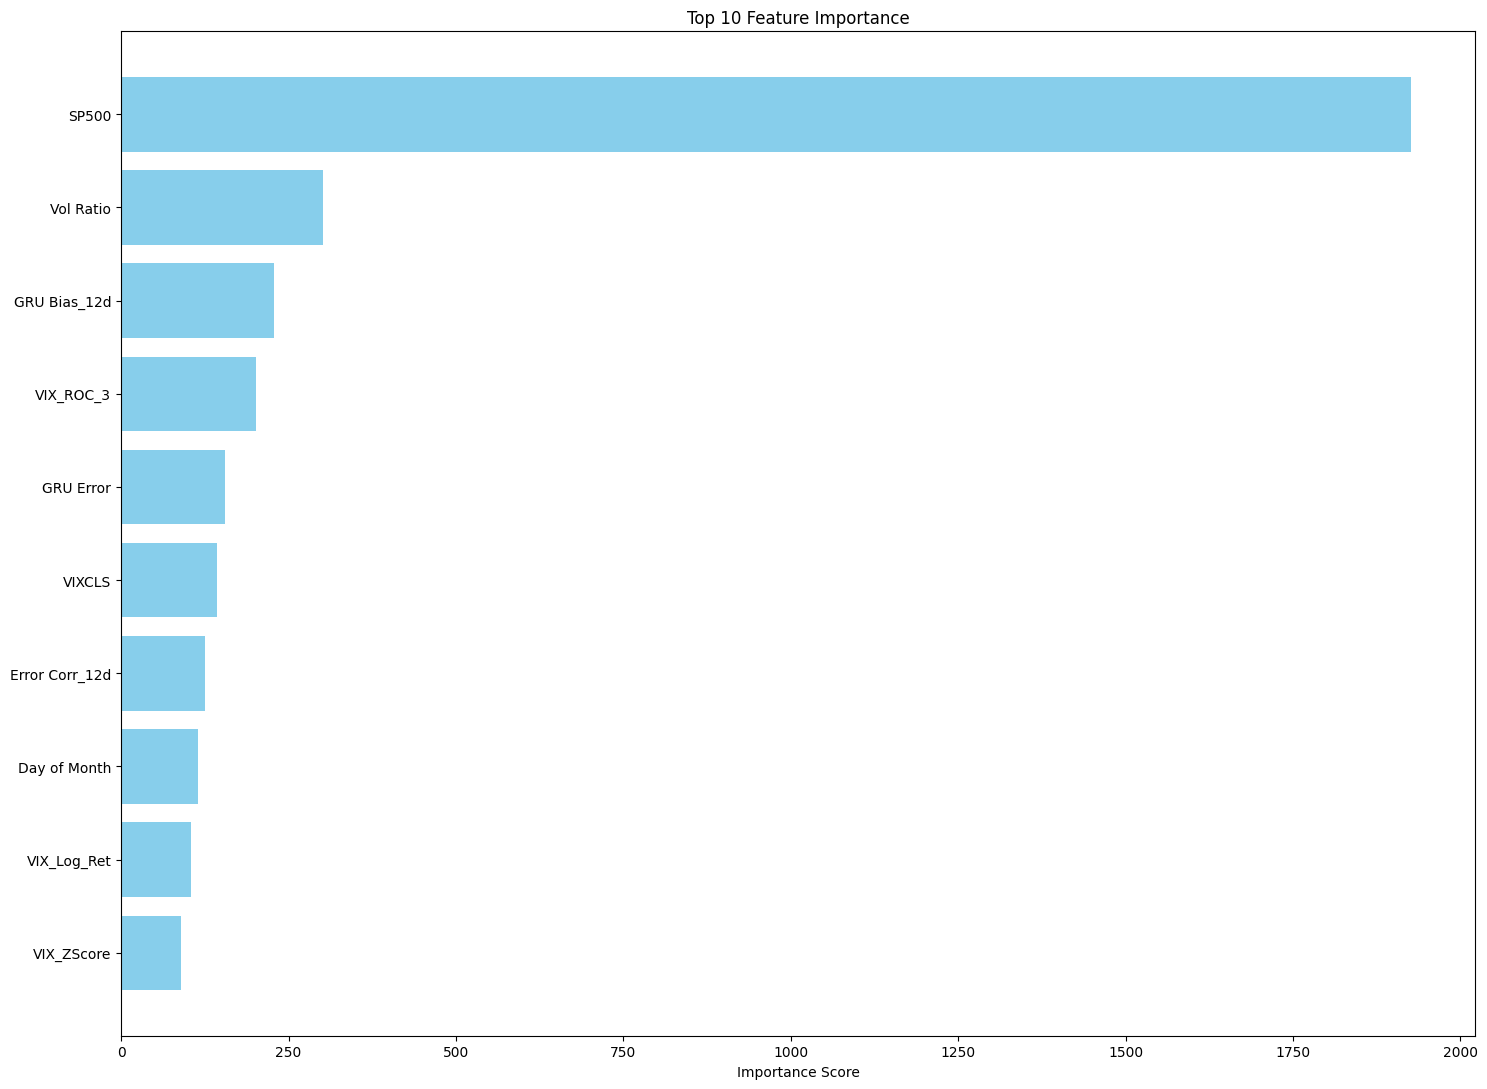

In [78]:
top_n = 10
plt.figure(figsize=(15, 11))
plt.barh(
    importance_df['Features'].head(top_n)[::-1],
    importance_df['Importance'].head(top_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance')
plt.tight_layout()
plt.show()

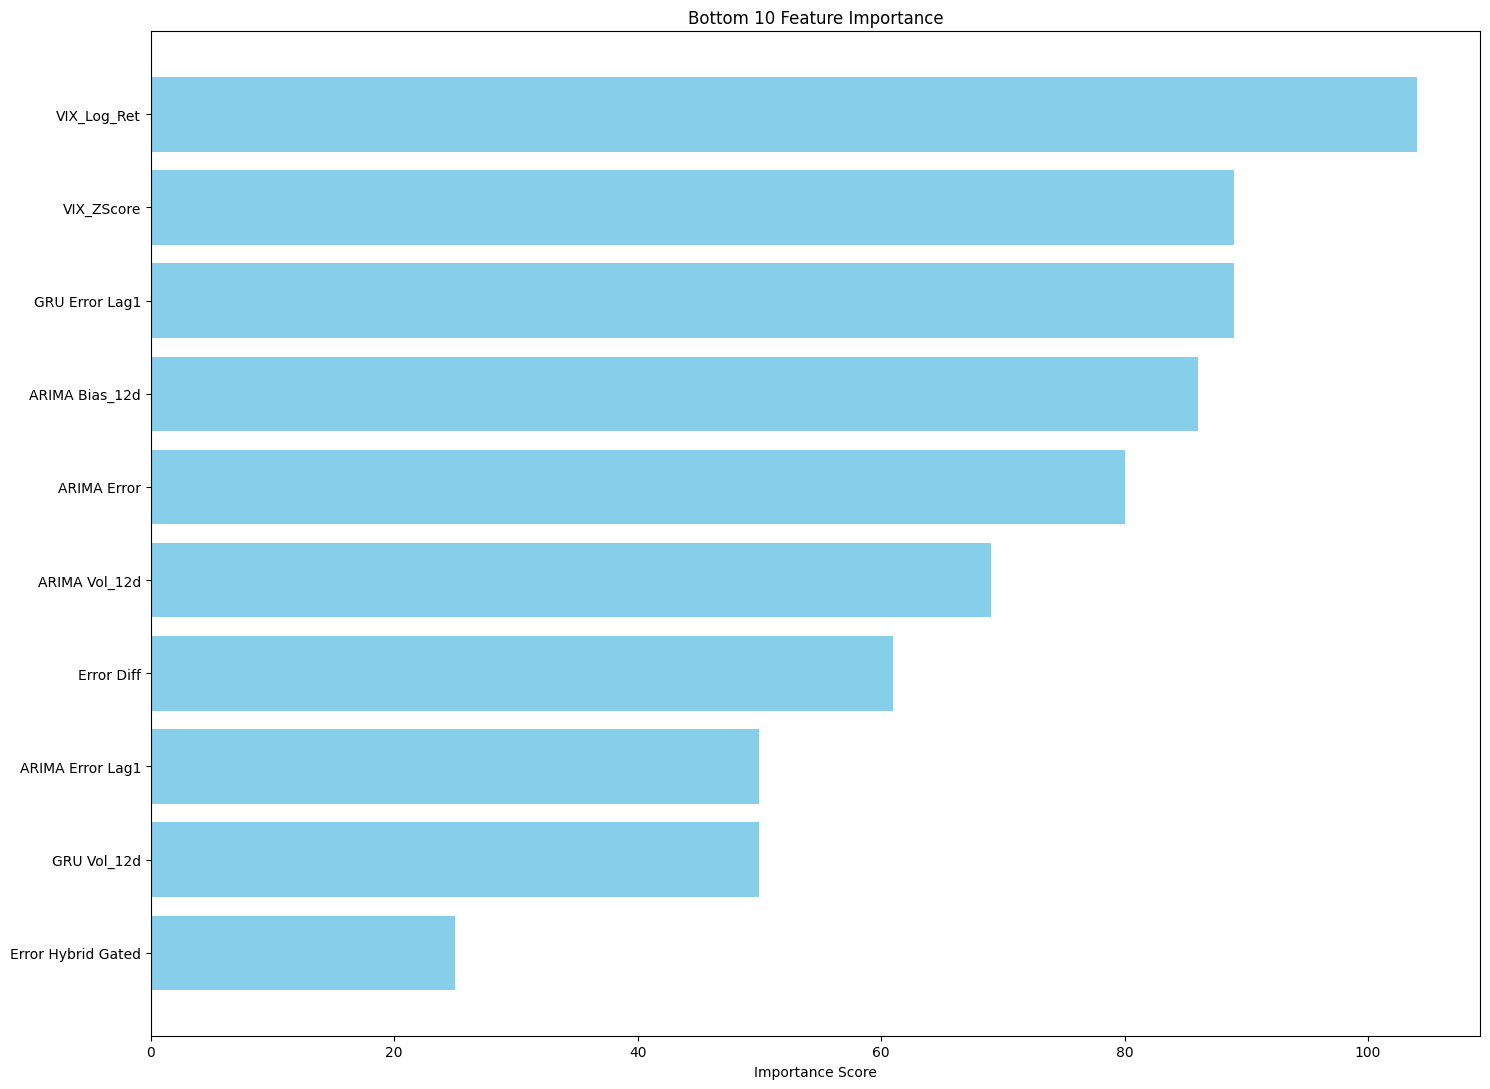

In [79]:
bottom_n = 10
plt.figure(figsize=(15, 11))
plt.barh(
    importance_df['Features'].tail(bottom_n)[::-1],
    importance_df['Importance'].tail(bottom_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance Score')
plt.title(f'Bottom {bottom_n} Feature Importance')
plt.tight_layout()
plt.show()

#### Graph of Actual vs Prediction Values

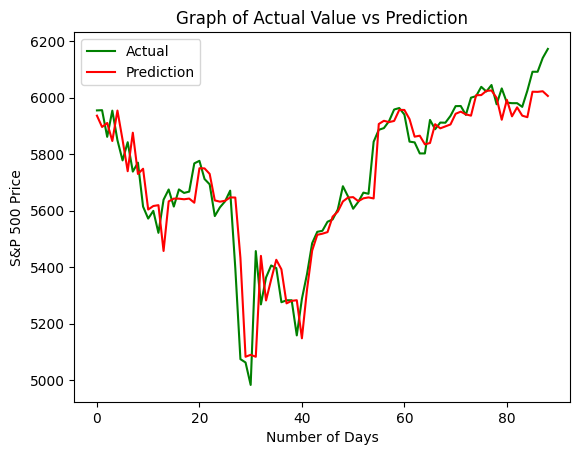

In [80]:
plt.plot(y_test.values, label="Actual", color='green')
plt.plot(y_pred, label="Prediction", color='red')

plt.title("Graph of Actual Value vs Prediction")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Model Residuals (Testing)

In [81]:
print(len(y_test))

89


In [82]:
print(len(y_pred))

89


In [83]:
residuals = np.squeeze(np.array(y_test)) - np.array(y_pred)

In [84]:
residuals_df = pd.DataFrame(residuals)

In [85]:
residuals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       89 non-null     float64
dtypes: float64(1)
memory usage: 844.0 bytes


In [86]:
residuals_df.describe()

,0
count,89.000000
mean,7.003492
std,91.911192
min,-358.554277
25%,-25.909258
50%,10.632852
75%,40.423457
max,374.355078


<Axes: title={'center': 'Residual Graph of XGBoost During Testing'}>

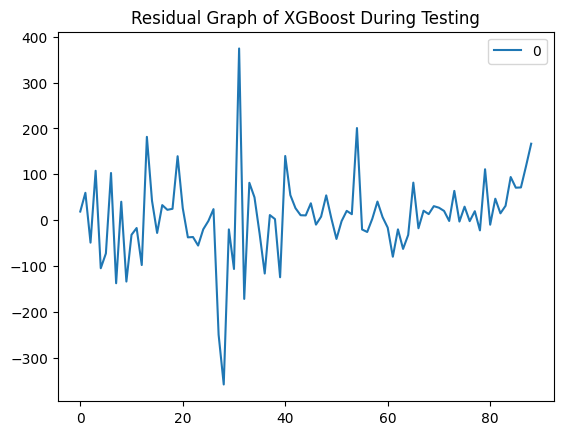

In [87]:
residuals_df.plot(title="Residual Graph of XGBoost During Testing")

<Axes: title={'center': 'Residual Density Graph'}, ylabel='Density'>

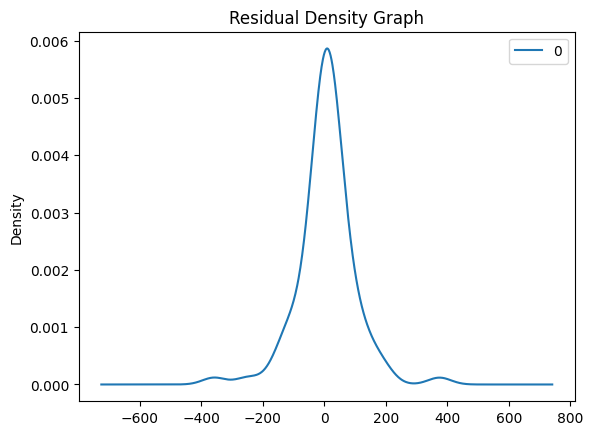

In [88]:
residuals_df.plot(kind='kde', title="Residual Density Graph")

## 6. Graph of Combined Results

#### Calculate ARIMA and GRU Prediction Values

In [89]:
"""
y_train list --> 
 - Col 0: SP500
 - Col 1: ARIMA Error
 - Col 2: GRU Error

Eliminate first row of data due to missing first row prediction after combining via XGBoost

Prediction Error = Actual - Prediction
Prediction = Actual - Prediction Error 

If prediction errors are prediction based on today (2/12/2025),
then y_true are actual value on tomorrow (3/12/2025)

To adjust for it, just slice first prediction which is 2/12/2025
Then slice the last y_true to adjust for prediction length
"""

gru_pred_lst = np.array(X_test['SP500']) - np.array(X_test['GRU Error'])
arima_pred_lst = np.array(X_test['SP500']) - np.array(X_test['ARIMA Error'])

gru_pred_lst = gru_pred_lst[1:]
arima_pred_lst = arima_pred_lst[1:]
rw_pred_lst = rw_pred_lst[1:]

In [90]:
print(f"Length of GRU prediction: {len(gru_pred_lst)}\n")

print(gru_pred_lst[:5])

Length of GRU prediction: 88

[5943.22119141 5911.12939453 5913.85058594 5819.57373047 5923.36474609]


In [91]:
print(f"Length of ARIMA prediction: {len(arima_pred_lst)}\n")

print(arima_pred_lst[:5])

Length of ARIMA prediction: 88

[5985.73543305 5957.57155696 5955.9928976  5869.40352037 5946.61951422]


In [92]:
print(f"Length of Random Walk ARIMA prediction: {len(rw_pred_lst)}\n")

print(rw_pred_lst[:5])

Length of Random Walk ARIMA prediction: 88

[5983.25 5955.25 5956.06 5861.57 5954.5 ]


#### Conversion of Variables

In [93]:
print(y_test[:5])

observation_date
2025-02-24    5955.25
2025-02-25    5956.06
2025-02-26    5861.57
2025-02-27    5954.50
2025-02-28    5849.72
Name: SP500, dtype: float64


In [94]:
new_y_test = y_test.values

# Adjust for prediction length
new_y_test = new_y_test[:-1]

In [95]:
print(new_y_test[:5])

[5955.25 5956.06 5861.57 5954.5  5849.72]


In [96]:
print(len(new_y_test))

88


#### Comparison between R2 Score of Models

In [97]:
new_y_pred = xgb_model.predict(X_test)

# Match the missing last prediction length
new_y_pred = new_y_pred[:-1]

print(len(new_y_pred))

print(new_y_pred[:5])

88
[5936.5933 5896.5034 5910.739  5846.86   5954.7617]


In [98]:
r2_rw = r2_score(y_true=new_y_test,
                 y_pred=rw_pred_lst)

r2_arima = r2_score(y_true=new_y_test,
                    y_pred=arima_pred_lst)

r2_gru = r2_score(y_true=new_y_test,
                  y_pred=gru_pred_lst)

r2_xgb = r2_score(y_true=new_y_test,
                  y_pred=new_y_pred)

In [99]:
r2_list = [r2_rw, r2_arima, r2_gru, r2_xgb]

r2_diff_with_xgb_list = [r2_rw-r2_xgb, r2_arima-r2_xgb, r2_gru-r2_xgb, 0.0000]

r2_diff_per_list = [r2_diff_with_xgb_list[0]*100/r2_xgb,
                    r2_diff_with_xgb_list[1]*100/r2_xgb,
                    r2_diff_with_xgb_list[2]*100/r2_xgb,
                    0.0000]

In [100]:
r2_table_dict = {
    'Model': ['Random Walk', 'ARIMA', 'GRU', 'XGB(ARIMA + GRU)'],
    'R2 Score': r2_list,
    'R2 Difference with XGB': r2_diff_with_xgb_list,
    'R2 Difference with XGB (Percentage)': r2_diff_per_list
}

r2_table_df = pd.DataFrame(r2_table_dict)

In [101]:
r2_table_df.style

,Model,R2 Score,R2 Difference with XGB,R2 Difference with XGB (Percentage)
0,Random Walk,0.872448,-0.008225,-0.933966
1,ARIMA,0.873036,-0.007637,-0.867229
2,GRU,0.854613,-0.026060,-2.959087
3,XGB(ARIMA + GRU),0.880673,0.000000,0.000000


#### Comparison between MAPE of All Models

In [102]:
mape_rw = mean_absolute_percentage_error(y_true=new_y_test,
                                         y_pred=rw_pred_lst)

mape_arima = mean_absolute_percentage_error(y_true=new_y_test,
                                            y_pred=arima_pred_lst)

mape_gru = mean_absolute_percentage_error(y_true=new_y_test,
                                          y_pred=gru_pred_lst)

mape_xgb = mean_absolute_percentage_error(y_true=new_y_test,
                                          y_pred=new_y_pred)

In [103]:
print(f"MAPE Percentage of Random Walk: {(mape_rw * 100):.5f}%")
print(f"MAPE Percentage of ARIMA: {(mape_arima * 100):.5f}%")
print(f"MAPE Percentage of GRU: {(mape_gru * 100):.5f}%")
print(f"MAPE Percentage of XGBoost: {(mape_xgb * 100):.5f}%")

MAPE Percentage of Random Walk: 1.06520%
MAPE Percentage of ARIMA: 1.07086%
MAPE Percentage of GRU: 1.31614%
MAPE Percentage of XGBoost: 1.05479%


#### Comparison between RMSE of All Models

In [104]:
rmse_rw = root_mean_squared_error(y_true=new_y_test,
                                  y_pred=rw_pred_lst)

rmse_arima = root_mean_squared_error(y_true=new_y_test,
                                     y_pred=arima_pred_lst)

rmse_gru = root_mean_squared_error(y_true=new_y_test,
                                   y_pred=gru_pred_lst)

rmse_xgb = root_mean_squared_error(y_true=new_y_test,
                                   y_pred=new_y_pred)

In [110]:
print(f"RMSE of Random Walk: {rmse_rw:.4f}")
print(f"RMSE of ARIMA: {rmse_arima:.4f}")
print(f"RMSE of GRU: {rmse_gru:.4f}")
print(f"RMSE of XGBoost: {rmse_xgb:.4f}")

RMSE of Random Walk: 93.5189
RMSE of ARIMA: 93.3032
RMSE of GRU: 99.8431
RMSE of XGBoost: 90.4534


#### Plotting Actual vs Prediction of XGBoost Only

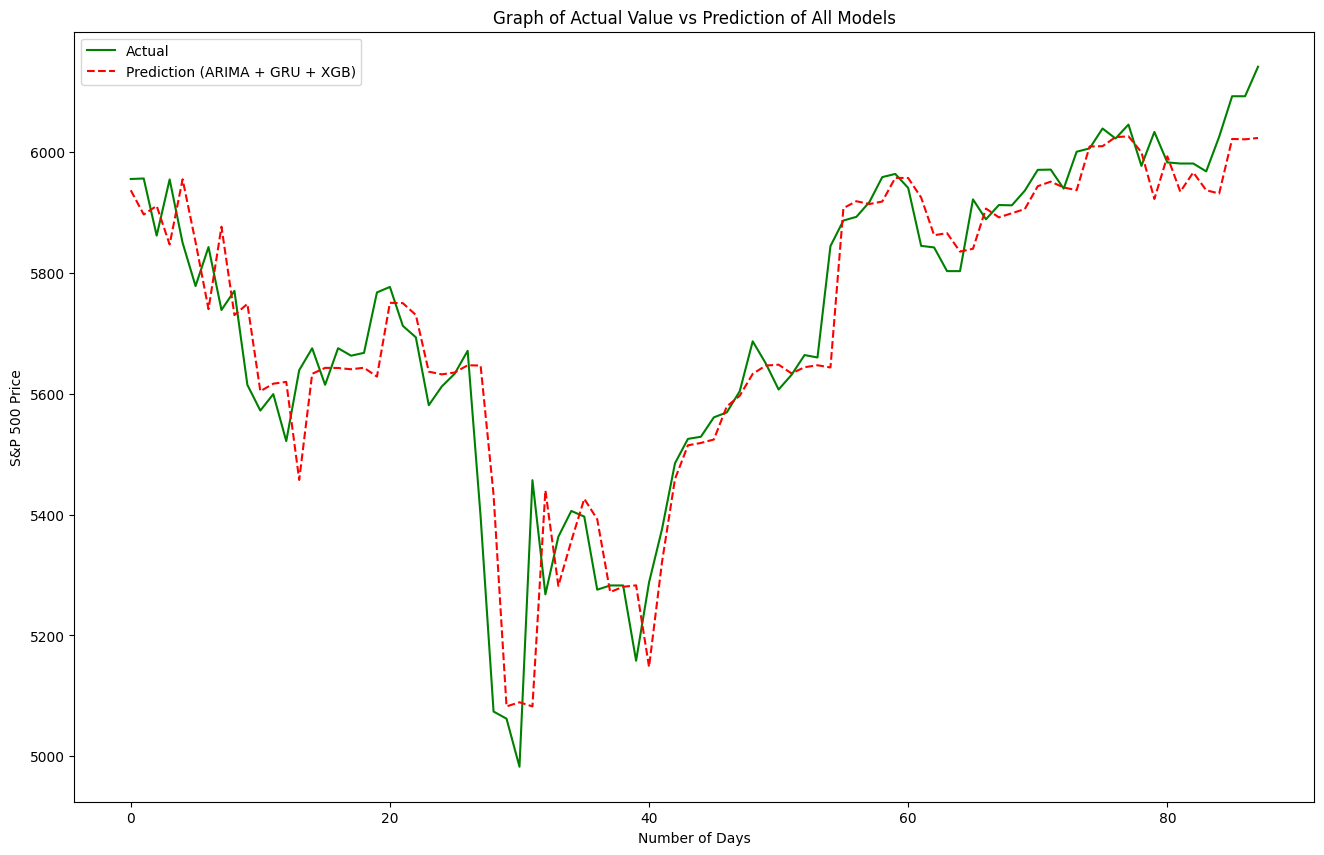

In [106]:
fig = plt.figure(figsize=(16, 10))

plt.plot(new_y_test, label="Actual", color='green')
plt.plot(new_y_pred, label="Prediction (ARIMA + GRU + XGB)", linestyle='dashed', color='red')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Plotting Actual vs Prediction of ARIMA and GRU

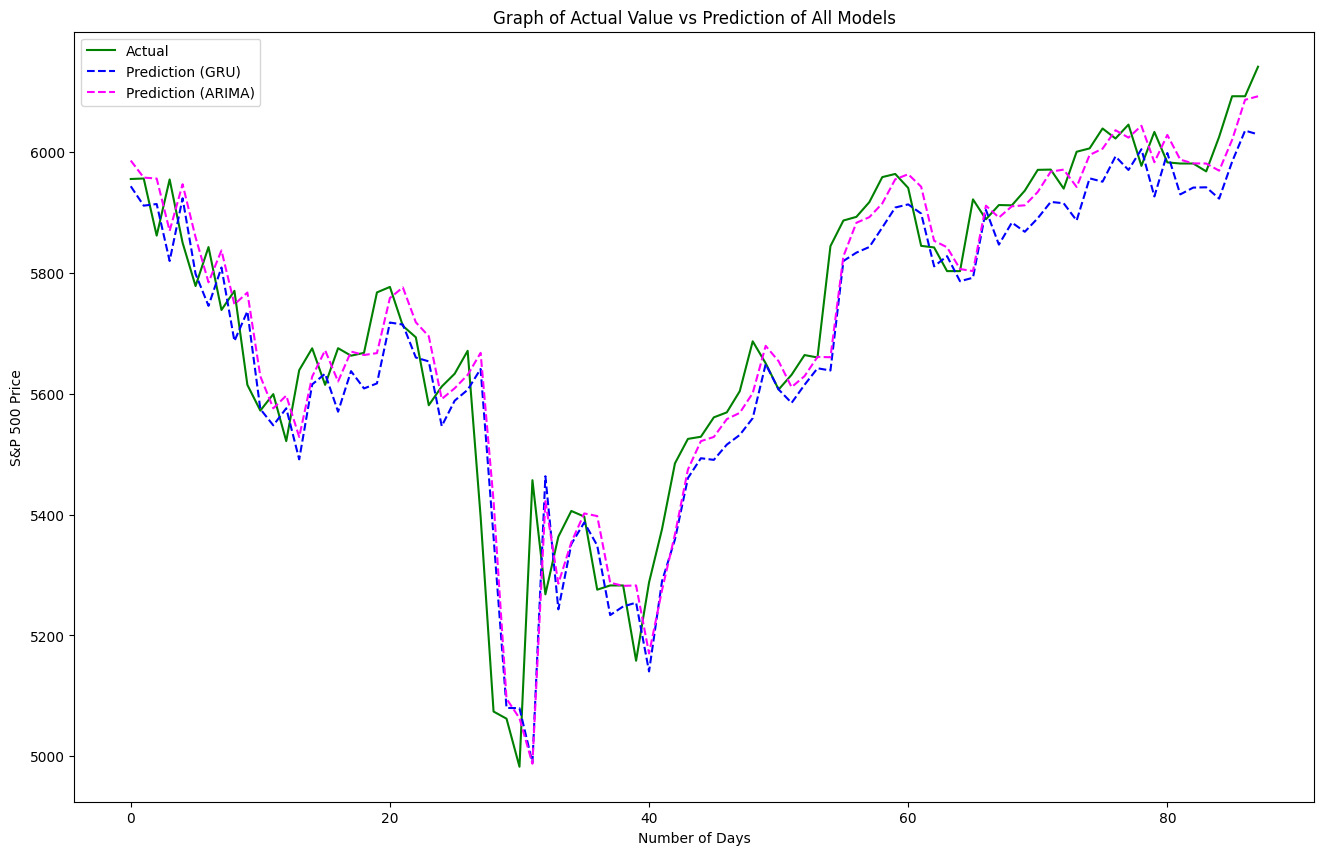

In [107]:
fig = plt.figure(figsize=(16, 10))

plt.plot(new_y_test, label="Actual", color='green')

plt.plot(gru_pred_lst, label="Prediction (GRU)", linestyle='dashed', color='blue')
plt.plot(arima_pred_lst, label="Prediction (ARIMA)", linestyle='dashed', color='magenta')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Plotting Actual vs Prediction of All Models

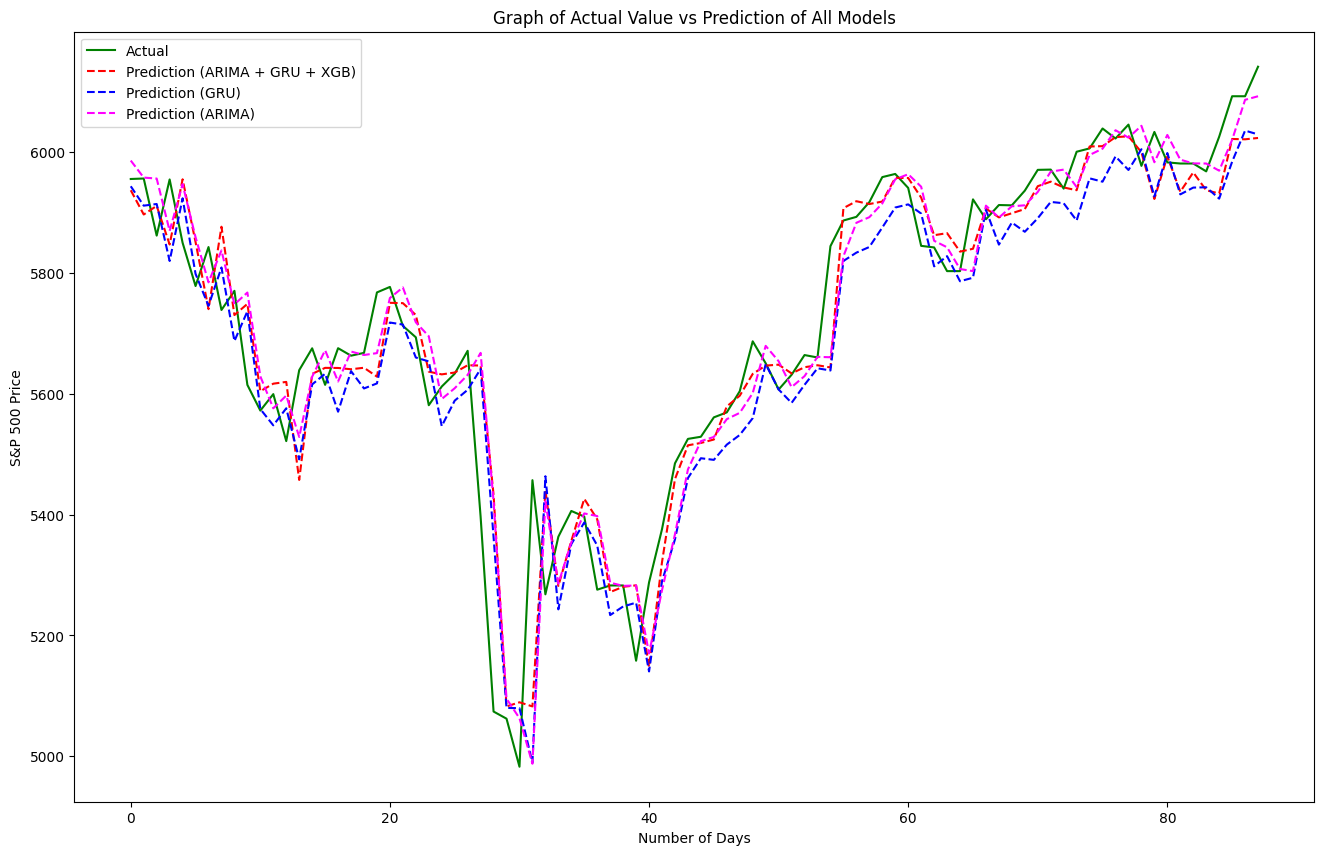

In [108]:
fig = plt.figure(figsize=(16, 10))

plt.plot(new_y_test, label="Actual", color='green')
plt.plot(new_y_pred, label="Prediction (ARIMA + GRU + XGB)", linestyle='dashed', color='red')

plt.plot(gru_pred_lst, label="Prediction (GRU)", linestyle='dashed', color='blue')
plt.plot(arima_pred_lst, label="Prediction (ARIMA)", linestyle='dashed', color='magenta')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Plotting Actual vs Prediction Graph of All Models (Sliding Window)

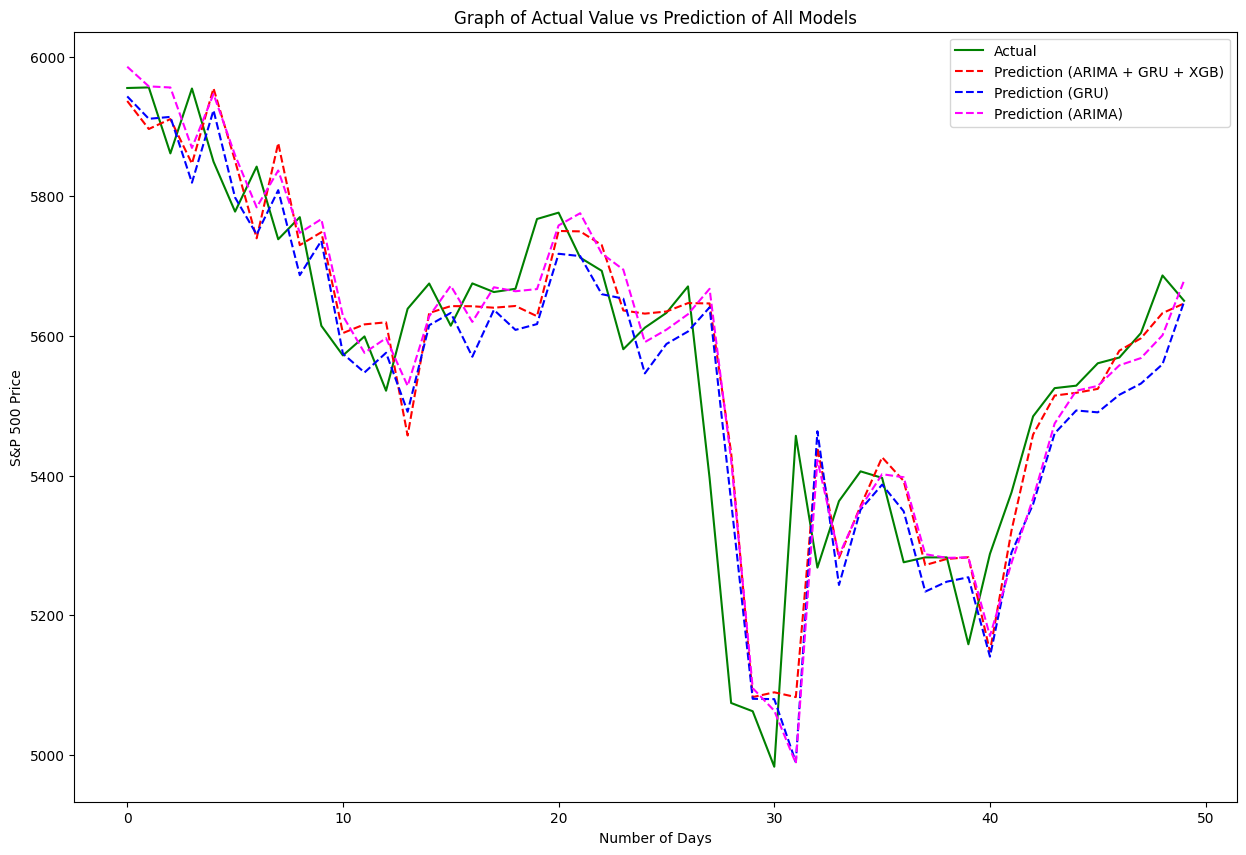

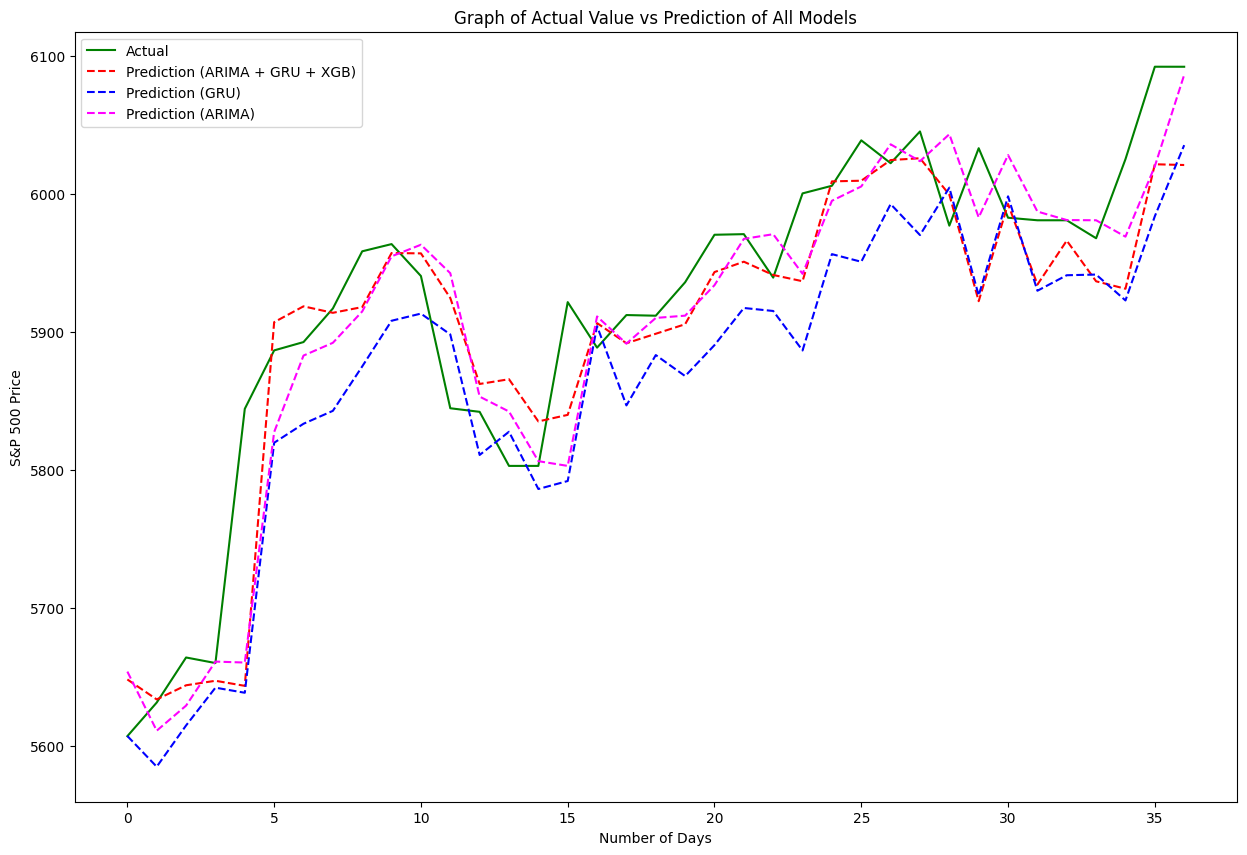

In [109]:
max_points_per_graph = 50

max_points_full = len(new_y_test)

current_points = 0

while(True):
    
    break_flag = False
    end_points = current_points + max_points_per_graph

    if end_points >= max_points_full:
        end_points = max_points_full-1
        break_flag = True
    
    fig = plt.figure(figsize=(15, 10))

    plt.plot(new_y_test[current_points : end_points], label="Actual", color='green')
    plt.plot(new_y_pred[current_points : end_points], label="Prediction (ARIMA + GRU + XGB)", linestyle='dashed', color='red')

    plt.plot(gru_pred_lst[current_points : end_points], label="Prediction (GRU)", linestyle='dashed', color='blue')
    plt.plot(arima_pred_lst[current_points : end_points], label="Prediction (ARIMA)", linestyle='dashed', color='magenta')

    plt.title("Graph of Actual Value vs Prediction of All Models")
    plt.xlabel("Number of Days")
    plt.ylabel("S&P 500 Price")

    plt.legend()
    plt.show()

    current_points += max_points_per_graph

    if break_flag:
        break